# Problem Framing 

The goal of this notebook is to develop and test different strategies of data imputation. We're gonna be using both supervised and unsupervised methods, and both traditional Machine Learning algorithms and state-of-the-art deep learning solutions.
The discriminative ML methods we're gonna be using are:
- KNN Imputer
- Iterative Imputer

And the DL methods include:
- Iterative Multi-layer Perceptron (MLP) Imputer
- Auto-encoder Imputer
- Generative Adversarial Network (GAN) Imputer

# Selecting a performance measure

In this notebook, we're working on the diabetes dataset, which includes numerical attributes only. A good performance measure would be the `root mean squared error` (RMSE) averaged over all the predicted columns.


# Download the data

In [1]:
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("mathchi/diabetes-data-set")

# print("Path to dataset files:", path)

## Take a quick look at the data

In [2]:
import pandas as pd

diabetes = pd.read_csv("C:/Users/imoua/.cache/kagglehub/datasets/mathchi/diabetes-data-set/versions/1/diabetes.csv")
diabetes.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [3]:
diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


We have 768 instances and 8 numerical attributes, the target column is categorical but has been ordinally encoded, so we can safely use it as continuous variable. <br>
None of the instances have missing values, so we will have to introduce missing data manually. We will take of that later.

In [4]:
diabetes.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


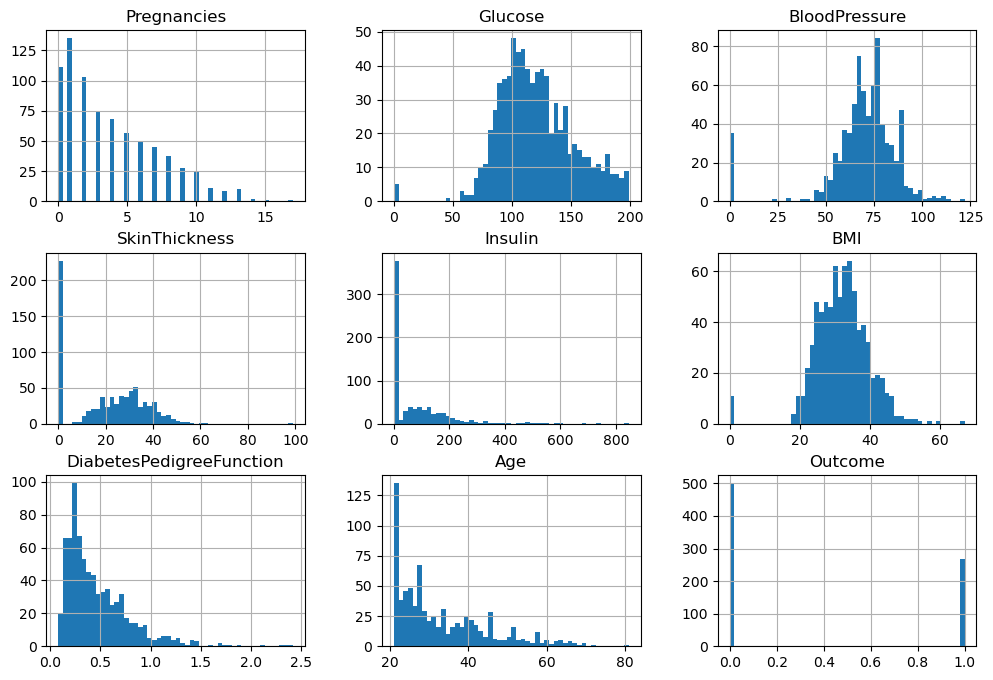

In [5]:
import matplotlib.pyplot as plt

diabetes.hist(bins=50, figsize=(12,8))
plt.show()

The first thing we can observe is the fact that many histograms are skewed right: Most data points are clustered toward the left side of the distribution, with a long tail on the right. They extend much farther to the right of the median than to the left, the mean is typically greater than the median. This may make it a bit harder for some machine learning algorithms to detect patterns. We will transform these attributes later to have more symmetrical and bell-shaped distributions. <br>
Another thing worth mentioning is that these attributes have very different scales. Most machine learning algorithms prefer attributes to have the same scales, e.g. neural networks tend to perform better with attributes with values ranging from -1 to 1.

# Create a Test set

Before transforming the data, it only seems logical to split the data into training and test splits. But before doing that, we're gonna have to introduce some missing data given the goal of this work.

To split the dataset into training and test sets, using random sampling methods is generally fine if your dataset is large enough (especially relative to the number of attributes), but if it is not you run the risk of introducing significant sampling bias.
To get a better estimation of the generalization error, the test set has to be representative of the population. For that reason we're gonna sample a test set stratified on the age categories in the dataset.

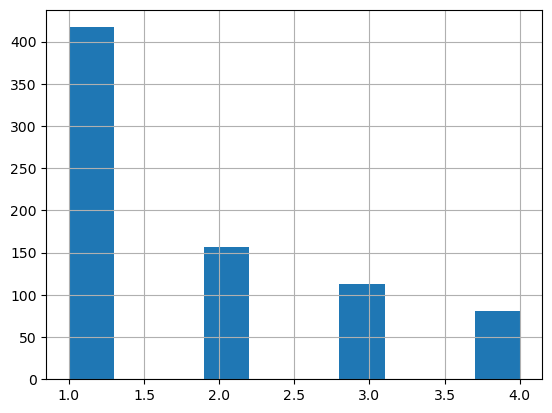

In [6]:
import numpy as np

diabetes["Age_cat"] = pd.cut(diabetes["Age"],
                            bins=[20, 30, 40, 50, np.inf],
                            labels=[1, 2, 3, 4])

diabetes.Age_cat.hist()
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(diabetes, test_size=0.1, stratify=diabetes["Age_cat"], random_state=42)

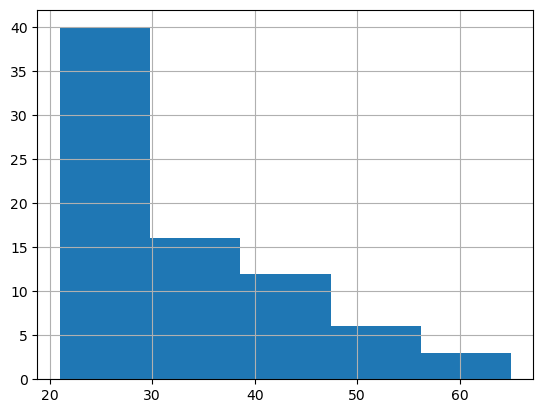

In [8]:
test_set["Age"].hist(bins=5)
plt.show()

In [9]:
# Drop Age_cat column because we won't use it again
for set_ in (train_set, test_set):
    set_.drop("Age_cat", axis=1, inplace=True)

In [10]:
import numpy as np

def introduceMissingValues(df, column_name, ratio):
    column = df[column_name].copy()
    num_missing_values = int(len(column) * ratio)
    random_indexes = np.random.choice(column.index, size=num_missing_values, replace=False)
    df.loc[random_indexes, column_name] = np.nan

In [11]:
train_set_clean = train_set.copy()

In [12]:
introduceMissingValues(train_set, "Insulin", ratio=0.3)
introduceMissingValues(train_set, "Glucose", ratio=0.3)
introduceMissingValues(train_set, "BloodPressure", ratio=0.3)

train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 691 entries, 623 to 122
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               691 non-null    int64  
 1   Glucose                   484 non-null    float64
 2   BloodPressure             484 non-null    float64
 3   SkinThickness             691 non-null    int64  
 4   Insulin                   484 non-null    float64
 5   BMI                       691 non-null    float64
 6   DiabetesPedigreeFunction  691 non-null    float64
 7   Age                       691 non-null    int64  
 8   Outcome                   691 non-null    int64  
dtypes: float64(5), int64(4)
memory usage: 70.1 KB


# Look for correlations

Since the dataset isn't too large, you can easily compute Person's r coefficient (standard correlation coefficient) between every pair of attributes

In [13]:
# Make a copy of the original training set we can revert to afterwards
diabetes = train_set.copy()

In [14]:
corr_matrix = diabetes.corr()
corr_matrix

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000000,0.144558,0.217448,-0.110236,-0.111109,-0.013255,-0.055854,0.547493,0.197231
Glucose,0.144558,1.000000,0.228470,0.023314,0.368853,0.237442,0.160353,0.268862,0.499371
BloodPressure,0.217448,0.228470,1.000000,0.226528,0.016860,0.341531,0.050070,0.283008,0.097964
SkinThickness,-0.110236,0.023314,0.226528,1.000000,0.443795,0.382308,0.176826,-0.127228,0.056837
Insulin,-0.111109,0.368853,0.016860,0.443795,1.000000,0.191726,0.172438,-0.024674,0.161625
BMI,-0.013255,0.237442,0.341531,0.382308,0.191726,1.000000,0.125896,0.033539,0.291834
DiabetesPedigreeFunction,-0.055854,0.160353,0.050070,0.176826,0.172438,0.125896,1.000000,0.026605,0.166563
Age,0.547493,0.268862,0.283008,-0.127228,-0.024674,0.033539,0.026605,1.000000,0.220255
Outcome,0.197231,0.499371,0.097964,0.056837,0.161625,0.291834,0.166563,0.220255,1.000000


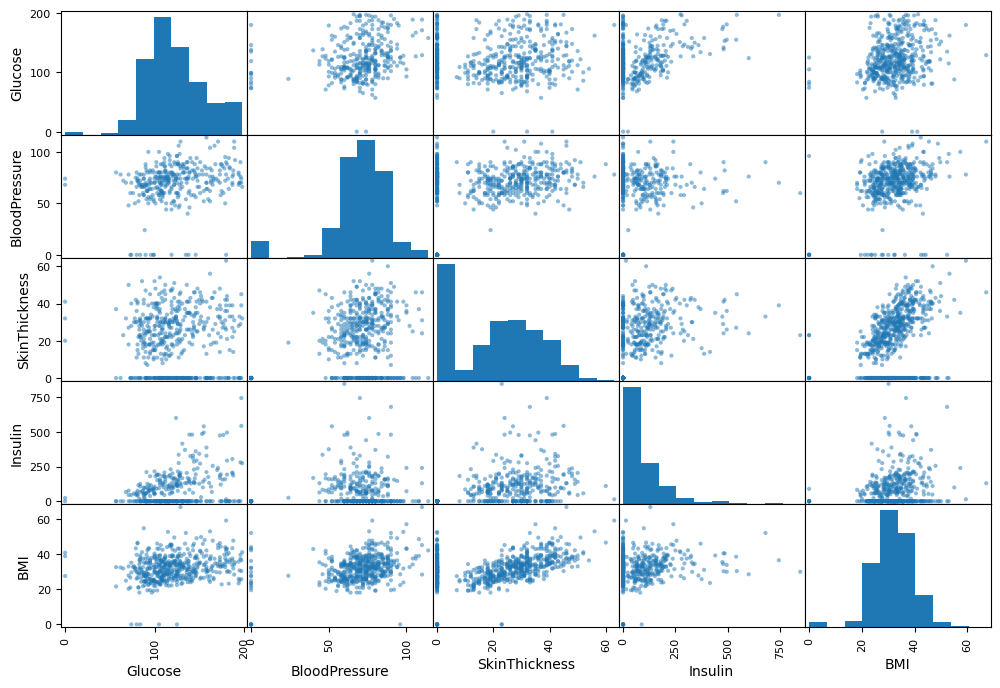

In [15]:
from pandas.plotting import scatter_matrix

attributes = ["Glucose", "BloodPressure", "SkinThickness", "Insulin", "BMI"]

scatter_matrix(diabetes[attributes], figsize=(12, 8))
plt.show()

# Prepare Data for ML algorithms

We observed that the attributes have very different scales and some have a long tail. It's about time we took care of that! <br>
There are several ways to scale data, the most famous methods include min-max scaling (Normalization) & Stdandardization (Z-score Normalization). When a feature's distribution has a heavy tail, both these methods will squash most values into a small range. So before scaling the features, we need to shrink the heavy tails, and if possible make the distribution roughly symmetrical.

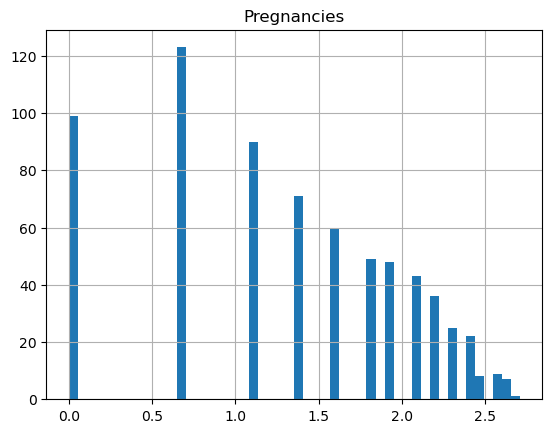

In [16]:
import matplotlib.pyplot as plt
# TODO : Measure information loss after transformation
pregnancies_transformed = np.log1p(diabetes[["Pregnancies"]])
pregnancies_transformed.hist(bins=50)
plt.show()

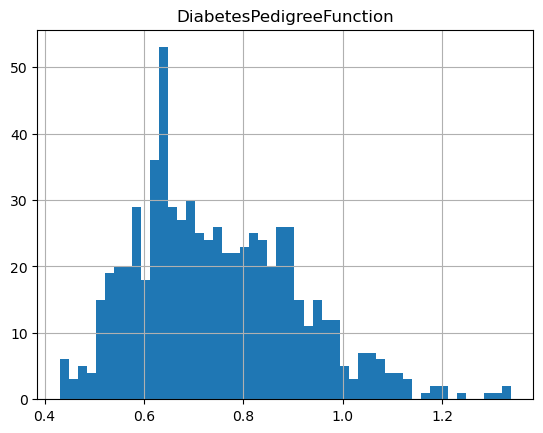

In [17]:
# TODO : Measure information loss after transformation
diabetesPedigreeFunction_transformed = np.power(diabetes[["DiabetesPedigreeFunction"]], 0.33)
diabetesPedigreeFunction_transformed.hist(bins=50)
plt.show()

<Axes: ylabel='Count'>

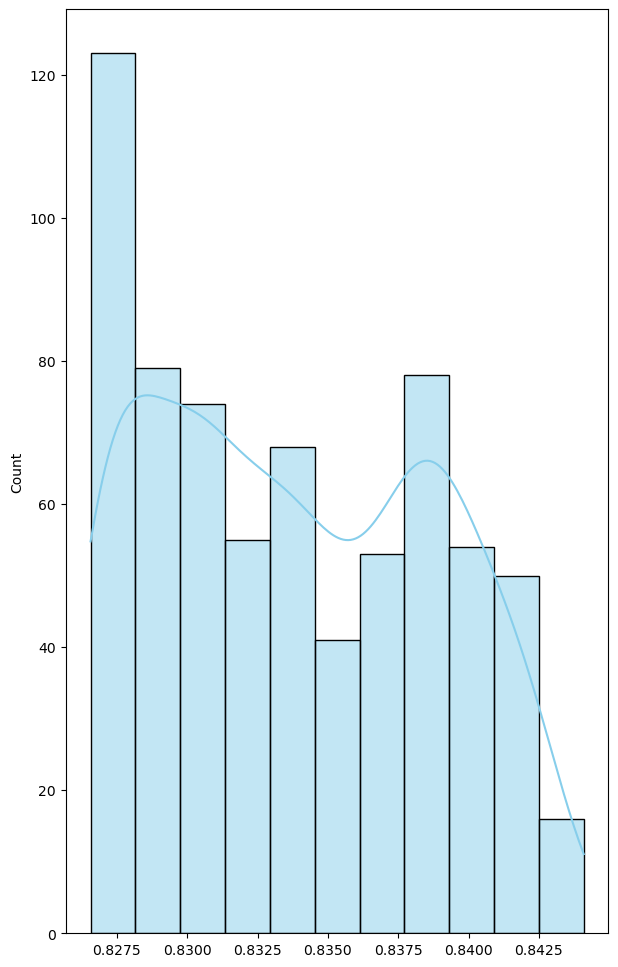

In [18]:
# TODO : Measure information loss after transformation
from scipy.stats import boxcox
import seaborn as sns

age_transformed, _ = boxcox(diabetes.Age + 1)
plt.figure(figsize=(7, 12))
sns.histplot(age_transformed, kde=True, color="skyblue")

In [19]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
diabetes_scaled = std_scaler.fit_transform(diabetes)

In [20]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, PowerTransformer, StandardScaler
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd

# Define the transformations for each column
transformers = [
    # Log1p transformation for "Pregnancies"
    ("pregnancies_log", FunctionTransformer(np.log1p), ["Pregnancies"]),
    
    # Cube root transformation for "DiabetesPedigreeFunction"
    ("diabetes_pedigree_cbrt", FunctionTransformer(lambda x: np.power(x, 0.33)), ["DiabetesPedigreeFunction"]),
    
    # Box-Cox transformation for "Age"
    ("age_boxcox", PowerTransformer(method='box-cox'), ["Age"]),  # Box-Cox requires strictly positive values.
]

# Combine all transformations
column_transformer = ColumnTransformer(
    transformers=transformers,
    remainder='passthrough'  # Keep other columns as they are
)

# Create a full preprocessing pipeline
preprocessing_pipeline = Pipeline([
    ("column_transform", column_transformer),  # Apply transformations
    ("scaler", StandardScaler()),  # Scale all features
])

# Fit and transform the data
preprocessed_train_set = preprocessing_pipeline.fit_transform(train_set)

# Convert the result back to a DataFrame for easier inspection
preprocessed_train_set_df = pd.DataFrame(preprocessed_train_set, columns=diabetes.columns)
preprocessed_train_set_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-1.715405,-0.270349,-1.477855,-0.872172,NaN,0.421240,0.253785,1.435620,-0.731817
1,0.635798,0.063197,-0.219377,NaN,0.259506,-1.295838,NaN,-0.264403,-0.731817
2,-1.715405,0.676527,0.137107,NaN,-3.585424,-1.295838,-0.697568,1.523121,1.366463
3,0.103734,-1.000105,-0.843100,1.495552,NaN,0.802812,NaN,0.160603,1.366463
4,-0.805836,0.274338,-0.667285,-0.195680,0.413304,0.548430,0.791507,0.510608,-0.731817
...,...,...,...,...,...,...,...,...,...
686,1.167862,0.704143,0.137107,NaN,0.310772,1.184385,NaN,-0.514406,1.366463
687,-0.805836,-0.057532,-0.843100,-1.087420,-0.099354,0.866408,-0.060575,0.698110,-0.731817
688,-1.715405,0.133397,-1.035181,-0.564676,-0.304417,0.166858,NaN,-0.526907,-0.731817
689,0.838079,-0.233409,-1.035181,-0.902922,-1.022137,0.612026,-0.168119,-0.414405,-0.731817


In [21]:
preprocessed_train_set_df = pd.DataFrame(preprocessed_train_set, columns=diabetes.columns)
preprocessed_train_set_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691 entries, 0 to 690
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               691 non-null    float64
 1   Glucose                   691 non-null    float64
 2   BloodPressure             691 non-null    float64
 3   SkinThickness             484 non-null    float64
 4   Insulin                   484 non-null    float64
 5   BMI                       691 non-null    float64
 6   DiabetesPedigreeFunction  484 non-null    float64
 7   Age                       691 non-null    float64
 8   Outcome                   691 non-null    float64
dtypes: float64(9)
memory usage: 48.7 KB


In [22]:
preprocessed_train_set_clean = preprocessing_pipeline.transform(train_set_clean)

In [23]:
from improved_gain import GAINImputer
data_x = preprocessed_train_set.copy()
gain_parameters = {
    'batch_size': 32,
    'hint_rate': 0.9,
    'alpha': 1,
    'iterations': 5
}

gain_imputer = GAINImputer(gain_parameters=gain_parameters)
imputed_data = gain_imputer.fit_transform(data_x)

100%|██████████| 5/5 [00:03<00:00,  1.53it/s]

Iteration 1/5 - D_loss: 0.6585, G_loss: 1.5546, MSE_loss: 1.4437


In [24]:
imputed_data_df = pd.DataFrame(imputed_data, columns=preprocessed_train_set_df.columns)
imputed_data_df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,-2.0,-0.270349,-1.477855,-0.872172,0.000000,0.421240,0.253785,1.435620,-1.0
1,1.0,0.063197,-0.219377,0.000000,0.259506,-1.295838,0.000000,-0.264403,-1.0
2,-2.0,0.676527,0.137107,0.000000,-3.585424,-1.295838,-0.697568,1.523121,1.0
3,0.0,-1.000105,-0.843100,1.495552,0.000000,0.802812,0.000000,0.160603,1.0
4,-1.0,0.274338,-0.667285,-0.195680,0.413304,0.548430,0.791507,0.510608,-1.0
...,...,...,...,...,...,...,...,...,...
686,1.0,0.704143,0.137107,0.000000,0.310772,1.184385,0.000000,-0.514406,1.0
687,-1.0,-0.057532,-0.843100,-1.087420,-0.099354,0.866408,-0.060575,0.698110,-1.0
688,-2.0,0.133397,-1.035181,-0.564676,-0.304417,0.166858,0.000000,-0.526907,-1.0
689,1.0,-0.233409,-1.035181,-0.902922,-1.022137,0.612026,-0.168119,-0.414405,-1.0


In [25]:
imputed_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 691 entries, 0 to 690
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               691 non-null    float64
 1   Glucose                   691 non-null    float64
 2   BloodPressure             691 non-null    float64
 3   SkinThickness             691 non-null    float64
 4   Insulin                   691 non-null    float64
 5   BMI                       691 non-null    float64
 6   DiabetesPedigreeFunction  691 non-null    float64
 7   Age                       691 non-null    float64
 8   Outcome                   691 non-null    float64
dtypes: float64(9)
memory usage: 48.7 KB


In [26]:
from gain_utils import imputation_rmse

missing_mask = np.isnan(preprocessed_train_set)

imputation_rmse(preprocessed_train_set_clean, imputed_data, missing_mask)

(0.9242917240286624,
 {'rmse': 0.9242917240286624,
  'mae': 0.6760782794833613,
  'total_missing': 621,
  'missing_percentage': 9.985528219971057,
  'min_error': 3.7626400319252085,
  'max_error': 4.092288166532079,
  'std_error': 0.9121641120501437})

In [27]:
# Introduce missing values in the test set

test_set_clean = test_set.copy()

introduceMissingValues(test_set, "Insulin", ratio=0.3)
introduceMissingValues(test_set, "Glucose", ratio=0.3)
introduceMissingValues(test_set, "BloodPressure", ratio=0.3)

test_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 77 entries, 646 to 754
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               77 non-null     int64  
 1   Glucose                   54 non-null     float64
 2   BloodPressure             54 non-null     float64
 3   SkinThickness             77 non-null     int64  
 4   Insulin                   54 non-null     float64
 5   BMI                       77 non-null     float64
 6   DiabetesPedigreeFunction  77 non-null     float64
 7   Age                       77 non-null     int64  
 8   Outcome                   77 non-null     int64  
dtypes: float64(5), int64(4)
memory usage: 8.1 KB


In [28]:
# Preprocess the test set

preprocessed_test_set = preprocessing_pipeline.transform(test_set)
preprocessed_test_set_clean = preprocessing_pipeline.transform(test_set_clean)

In [29]:
pd.DataFrame(preprocessed_test_set, columns=diabetes.columns).info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               77 non-null     float64
 1   Glucose                   77 non-null     float64
 2   BloodPressure             77 non-null     float64
 3   SkinThickness             54 non-null     float64
 4   Insulin                   54 non-null     float64
 5   BMI                       77 non-null     float64
 6   DiabetesPedigreeFunction  54 non-null     float64
 7   Age                       77 non-null     float64
 8   Outcome                   77 non-null     float64
dtypes: float64(9)
memory usage: 5.5 KB


In [30]:
# Impute missing values in the test set

imputed_test_set = gain_imputer.transform(preprocessed_test_set.copy())

In [31]:
# Compute the RMSE of the imputed test set

missing_mask_test = np.isnan(preprocessed_test_set)

# Check if there are any missing values in the preprocessed_test_set
if missing_mask_test.any():
	rmse = imputation_rmse(preprocessed_test_set_clean, imputed_test_set, missing_mask_test)
	print(f"RMSE: {rmse}")
else:
	print("No missing values in the preprocessed_test_set to compute RMSE.")

RMSE: (1.012981311250977, {'rmse': 1.012981311250977, 'mae': 0.7810497839137859, 'total_missing': 69, 'missing_percentage': 9.956709956709958, 'min_error': 4.139354666702044, 'max_error': 2.1174117515710775, 'std_error': 0.8724498656445012})


In [32]:
# from gain_utils import plot_imputation_errors

# plot_imputation_errors()